<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-the-Bayesian-Hyperparameter-Optimisation-Algorithm" data-toc-modified-id="Import-the-Bayesian-Hyperparameter-Optimisation-Algorithm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import the Bayesian Hyperparameter Optimisation Algorithm</a></span></li><li><span><a href="#Example-Use-Case" data-toc-modified-id="Example-Use-Case-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example Use Case</a></span><ul class="toc-item"><li><span><a href="#Generate-some-tarining-data" data-toc-modified-id="Generate-some-tarining-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generate some tarining data</a></span></li><li><span><a href="#Run-the-Optimisation" data-toc-modified-id="Run-the-Optimisation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run the Optimisation</a></span></li><li><span><a href="#Plot-the-Samples" data-toc-modified-id="Plot-the-Samples-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot the Samples</a></span></li></ul></li><li><span><a href="#Advanced-User-defined-Inputs" data-toc-modified-id="Advanced-User-defined-Inputs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Advanced User-defined Inputs</a></span><ul class="toc-item"><li><span><a href="#Providing-your-own-scoring-function" data-toc-modified-id="Providing-your-own-scoring-function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Providing your own scoring function</a></span><ul class="toc-item"><li><span><a href="#Example-1" data-toc-modified-id="Example-1-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Example 1</a></span></li><li><span><a href="#Example-2" data-toc-modified-id="Example-2-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Example 2</a></span></li></ul></li><li><span><a href="#Convergence-Diagnostics" data-toc-modified-id="Convergence-Diagnostics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Convergence Diagnostics</a></span></li></ul></li><li><span><a href="#Using-random_search-solver-for-discrete-valued-hyperparameters" data-toc-modified-id="Using-random_search-solver-for-discrete-valued-hyperparameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Using random_search solver for discrete valued hyperparameters</a></span></li><li><span><a href="#Ignore-this-for-now..." data-toc-modified-id="Ignore-this-for-now...-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Ignore this for now...</a></span></li></ul></div>

In [1]:
# That is setting up the autoreload mode to automatically 
# reload your imports when you edit a file
%load_ext autoreload
%autoreload 2

# Import the Bayesian Hyperparameter Optimisation Algorithm

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
from bayesian_hyperparameter_optimisation_3 import BayesianOptimisation
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF
import matplotlib.pyplot as plt

# Example Use Case
## Generate some tarining data

In [19]:
def generate_noisy_data_from_bivariate_gaussian(z):
    
    "Define a simple 2-D gaussian to generate noisy data"
    
    x = z[:,0].reshape(-1,1)
    y = z[:,1].reshape(-1,1)
    return 1-np.exp(-((x-5)/10)**2)*np.exp(-((y-10)/10)**2)+0.1*np.random.uniform(size=(1000,1))#,loc=0,scale=1)

def generate_noisy_data_from_bivariate_gaussian_nd(z, mu, sig):
    
    "Define a simple 3-D gaussian to generate noisy data"
    
    G = np.ones((z.shape[0],1))
    for i in range(z.shape[1]):
        G = G*np.exp(-((z[:,i]-mu[i])/sig[i])**2).reshape(-1,1)
    
    return 1-G+0.1*np.random.uniform(size=(1000,1))


# --- Generate our training data

# Generate random x data from 0 to 15
X_train = 15*np.random.uniform(size=(1000,2))
# Generate noisy data from a 2D gaussian defined above
y_train = generate_noisy_data_from_bivariate_gaussian(X_train)
y_train = y_train.ravel()




## Run the Optimisation

In [102]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
#     'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = RandomForestRegressor(random_state=42),
    NpI = 5,
    Niter = 95,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10
)
BOout.optimise()

ndim: 0
{'max_depth': 6, 'n_estimators': 6} score: 0.9593846302314712
{'max_depth': 1, 'n_estimators': 10} score: 0.554417949890885
{'max_depth': 3, 'n_estimators': 2} score: 0.8821281604580913
{'max_depth': 8, 'n_estimators': 13} score: 0.9723970158795666


INFO:root:Will perform 95 iterations
INFO:root:Iteration 0


{'max_depth': 5, 'n_estimators': 17} score: 0.9478169130823251


ValueError: cannot reshape array of size 2 into shape (0)

## Plot the Samples

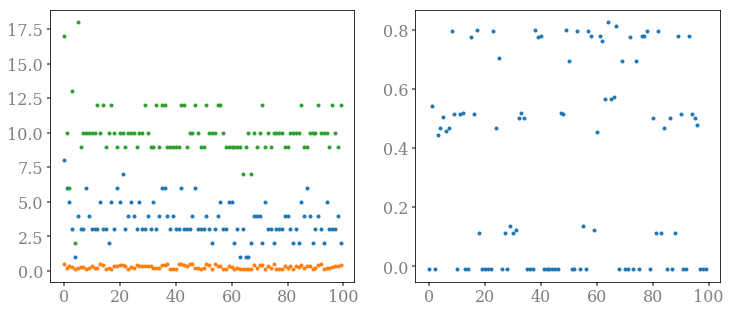

In [36]:
# --- Track the results with each iteration

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(BOout.Xt,'.')
plt.subplot(122)
plt.plot(BOout.Yt,'.')

plt.show()

In [9]:
best_params = BOout.Xt[np.argmax(BOout.Yt)]
RFr = RandomForestRegressor(
    min_samples_leaf=best_params[0],
    random_state=42
).fit(X_train,y_train)
np.mean(cross_val_score(RFr, X_train,y_train, cv=5))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7700969003203069

# Advanced User-defined Inputs
## Providing your own scoring function

### Example 1

In [34]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
    'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

def my_scoring_function(X_train, y_train):
    return MLmodel.score(X_train, y_train)

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    scoring_function = my_scoring_function,
    NpI = 5,
    Niter = 95,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10,
).optimise()

INFO:root:Will perform 95 iterations
INFO:root:Iteration 0
INFO:root:Iteration 1


{'max_depth': 1, 'min_samples_leaf': 0.30000000000000004, 'n_estimators': 13} score: 0.44528430312364015
{'max_depth': 3, 'min_samples_leaf': 0.4600000000000001, 'n_estimators': 17} score: -0.008378617416458178
{'max_depth': 6, 'min_samples_leaf': 0.38, 'n_estimators': 2} score: -0.012146062392077406
{'max_depth': 8, 'min_samples_leaf': 0.22000000000000003, 'n_estimators': 10} score: 0.5426162011160974
{'max_depth': 5, 'min_samples_leaf': 0.14, 'n_estimators': 6} score: 0.7782525552890325
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 9} score: 0.12398975013204641
current accuracy: 0.12398975013204641
best accuracy: 0.7782525552890325
next iteration


INFO:root:Iteration 2
INFO:root:Iteration 3
INFO:root:Iteration 4


{'max_depth': 6, 'min_samples_leaf': 0.48, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.48, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.16000000000000003, 'n_estimators': 10} score: 0.7779499751645844
current accuracy: 0.7779499751645844
best accuracy: 0.7782525552890325
next iteration


INFO:root:Iteration 5
INFO:root:Iteration 6
INFO:root:Iteration 7
INFO:root:Iteration 8


{'max_depth': 3, 'min_samples_leaf': 0.24000000000000002, 'n_estimators': 10} score: 0.5148707931739177
current accuracy: 0.5148707931739177
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.2, 'n_estimators': 7} score: 0.6744583836414535
current accuracy: 0.6744583836414535
best accuracy: 0.7782525552890325


INFO:root:Iteration 9
INFO:root:Iteration 10


next iteration
{'max_depth': 4, 'min_samples_leaf': 0.3600000000000001, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.28, 'n_estimators': 10} score: 0.46852619298481
current accuracy: 0.46852619298481
best accuracy: 0.7782525552890325
next iteration


INFO:root:Iteration 11
INFO:root:Iteration 12
INFO:root:Iteration 13


{'max_depth': 4, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.4, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.48, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration


INFO:root:Iteration 14
INFO:root:Iteration 15
INFO:root:Iteration 16


{'max_depth': 6, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7782525552890325
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.28001474376176705, 'n_estimators': 12} score: 0.47885622560997254
current accuracy: 0.47885622560997254
best accuracy: 0.7966941788055276
next iteration


INFO:root:Iteration 17
INFO:root:Iteration 18
INFO:root:Iteration 19


{'max_depth': 4, 'min_samples_leaf': 0.16000000000000003, 'n_estimators': 10} score: 0.7779499751645844
current accuracy: 0.7779499751645844
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 9} score: 0.12398975013204641
current accuracy: 0.12398975013204641
best accuracy: 0.7966941788055276
next iteration


INFO:root:Iteration 20
INFO:root:Iteration 21
INFO:root:Iteration 22


{'max_depth': 3, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.3600000000000001, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.4800000972976031, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7966941788055276
next iteration


INFO:root:Iteration 23
INFO:root:Iteration 24
INFO:root:Iteration 25


{'max_depth': 5, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.4, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7966941788055276
next iteration


INFO:root:Iteration 26
INFO:root:Iteration 27


{'max_depth': 3, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7966941788055276
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.11999999872730176, 'n_estimators': 9} score: 0.7981373572444003
current accuracy: 0.7981373572444003
best accuracy: 0.7981373572444003
next iteration


INFO:root:Iteration 28
INFO:root:Iteration 29
INFO:root:Iteration 30


{'max_depth': 6, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.7981373572444003
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.4, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.7981373572444003
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.2000115685239166, 'n_estimators': 10} score: 0.7043018952806764
current accuracy: 0.7043018952806764
best accuracy: 0.7981373572444003
next iteration


INFO:root:Iteration 31
INFO:root:Iteration 32
INFO:root:Iteration 33


{'max_depth': 5, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 12} score: 0.8002983920390958
current accuracy: 0.8002983920390958
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.43999545962083364, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 34
INFO:root:Iteration 35
INFO:root:Iteration 36


{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.2, 'n_estimators': 9} score: 0.6948271931798515
current accuracy: 0.6948271931798515
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958


INFO:root:Iteration 37
INFO:root:Iteration 38
INFO:root:Iteration 39


next iteration
{'max_depth': 2, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 40
INFO:root:Iteration 41


{'max_depth': 5, 'min_samples_leaf': 0.2, 'n_estimators': 9} score: 0.6948271931798515
current accuracy: 0.6948271931798515
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.3600001036287043, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 42
INFO:root:Iteration 43


{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.31999992754119416, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 44
INFO:root:Iteration 45


{'max_depth': 3, 'min_samples_leaf': 0.48, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.1200370370401015, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 46
INFO:root:Iteration 47


{'max_depth': 3, 'min_samples_leaf': 0.39996616040220945, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.12002557953848737, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 48
INFO:root:Iteration 49


{'max_depth': 5, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.11999905591870905, 'n_estimators': 10} score: 0.7964020277097115
current accuracy: 0.7964020277097115
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 50
INFO:root:Iteration 51


{'max_depth': 3, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.27998250288513193, 'n_estimators': 9} score: 0.45290613797064994
current accuracy: 0.45290613797064994
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 52
INFO:root:Iteration 53


{'max_depth': 4, 'min_samples_leaf': 0.48, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.44000003160733664, 'n_estimators': 7} score: -0.010515454502098143
current accuracy: -0.010515454502098143
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 54
INFO:root:Iteration 55


{'max_depth': 2, 'min_samples_leaf': 0.31998306180655145, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.4399842839172108, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 56
INFO:root:Iteration 57


{'max_depth': 6, 'min_samples_leaf': 0.1999983346845634, 'n_estimators': 9} score: 0.6948271931798515
current accuracy: 0.6948271931798515
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.24003166356066233, 'n_estimators': 9} score: 0.5022439460506452
current accuracy: 0.5022439460506452
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 58
INFO:root:Iteration 59


{'max_depth': 6, 'min_samples_leaf': 0.4, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.31999820241602606, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 60
INFO:root:Iteration 61


{'max_depth': 3, 'min_samples_leaf': 0.4, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.48, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 62
INFO:root:Iteration 63


{'max_depth': 5, 'min_samples_leaf': 0.36000018577592724, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.31999681829377796, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 64
INFO:root:Iteration 65


{'max_depth': 4, 'min_samples_leaf': 0.12001909583602356, 'n_estimators': 10} score: 0.7966941788055276
current accuracy: 0.7966941788055276
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.3999864330746391, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 66
INFO:root:Iteration 67


{'max_depth': 5, 'min_samples_leaf': 0.43998636646125766, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.23999122820306898, 'n_estimators': 9} score: 0.5030954049197514
current accuracy: 0.5030954049197514
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 68
INFO:root:Iteration 69


{'max_depth': 5, 'min_samples_leaf': 0.4399857225319034, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.47992457144770695, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 70
INFO:root:Iteration 71


{'max_depth': 3, 'min_samples_leaf': 0.11999624486391751, 'n_estimators': 9} score: 0.7981373572444003
current accuracy: 0.7981373572444003
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.39996194155471587, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 72
INFO:root:Iteration 73


{'max_depth': 6, 'min_samples_leaf': 0.24002371081611523, 'n_estimators': 10} score: 0.5148707931739177
current accuracy: 0.5148707931739177
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.23999989870287225, 'n_estimators': 10} score: 0.5156684657279785
current accuracy: 0.5156684657279785
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 74
INFO:root:Iteration 75


{'max_depth': 3, 'min_samples_leaf': 0.16003943457918282, 'n_estimators': 9} score: 0.7758889566588596
current accuracy: 0.7758889566588596
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 7, 'min_samples_leaf': 0.11999852177807155, 'n_estimators': 10} score: 0.7964020277097115
current accuracy: 0.7964020277097115
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 76
INFO:root:Iteration 77


{'max_depth': 4, 'min_samples_leaf': 0.3199459543431613, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 6, 'min_samples_leaf': 0.28, 'n_estimators': 9} score: 0.45724519226796384
current accuracy: 0.45724519226796384
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 78
INFO:root:Iteration 79


{'max_depth': 3, 'min_samples_leaf': 0.31999305092893116, 'n_estimators': 10} score: 0.16196401665439014
current accuracy: 0.16196401665439014
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.35999837553072195, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 80
INFO:root:Iteration 81


{'max_depth': 3, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.4, 'n_estimators': 12} score: -0.008587570224572082
current accuracy: -0.008587570224572082
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 82
INFO:root:Iteration 83


{'max_depth': 2, 'min_samples_leaf': 0.2, 'n_estimators': 10} score: 0.7057872101137947
current accuracy: 0.7057872101137947
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.15999878735054424, 'n_estimators': 9} score: 0.7772455185040268
current accuracy: 0.7772455185040268
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 84
INFO:root:Iteration 85


{'max_depth': 3, 'min_samples_leaf': 0.28, 'n_estimators': 10} score: 0.46852619298481
current accuracy: 0.46852619298481
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 4, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 10} score: 0.11200043782181188
current accuracy: 0.11200043782181188
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 86
INFO:root:Iteration 87


{'max_depth': 4, 'min_samples_leaf': 0.11999085721966167, 'n_estimators': 7} score: 0.7962059664031744
current accuracy: 0.7962059664031744
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.3600000000000001, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 88
INFO:root:Iteration 89


{'max_depth': 3, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 9} score: 0.7990162760853565
current accuracy: 0.7990162760853565
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.39995252686346705, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 90
INFO:root:Iteration 91


{'max_depth': 3, 'min_samples_leaf': 0.4799982599970509, 'n_estimators': 10} score: -0.009335740534074289
current accuracy: -0.009335740534074289
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 3, 'min_samples_leaf': 0.4399880095913341, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Iteration 92
INFO:root:Iteration 93
INFO:root:Iteration 94


{'max_depth': 4, 'min_samples_leaf': 0.12000000000000001, 'n_estimators': 9} score: 0.7990162760853565
current accuracy: 0.7990162760853565
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 5, 'min_samples_leaf': 0.28, 'n_estimators': 10} score: 0.46852619298481
current accuracy: 0.46852619298481
best accuracy: 0.8002983920390958
next iteration
{'max_depth': 2, 'min_samples_leaf': 0.44000000000000006, 'n_estimators': 9} score: -0.00957459560700884
current accuracy: -0.00957459560700884
best accuracy: 0.8002983920390958
next iteration


INFO:root:Best result 0.8002983920390958: Params: [ 5.    0.12 12.  ]
INFO:root:Best result 0.8002983920390958: Params: {'bootstrap': 5.0, 'criterion': 0.12000000000000001, 'max_depth': 12.0}


{'max_depth': 5, 'min_samples_leaf': 0.32000000000000006, 'n_estimators': 9} score: 0.12398975013204641
current accuracy: 0.12398975013204641
best accuracy: 0.8002983920390958


### Example 2

In [ ]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
    'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    scoring_function = MLmodel.score,
    NpI = 5,
    Niter = 95,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10,
).optimise()

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
INFO:root:Will perform 95 iterations
INFO:root:Iteration 0
INFO:root:Iteration 1
INFO:root:Iteration 2


{'min_samples_leaf': 0.22000000000000003} 0.4813176890428952
{'min_samples_leaf': 0.14} 0.7611842226514938
{'min_samples_leaf': 0.4600000000000001} -8.105585937734361e-05
{'min_samples_leaf': 0.30000000000000004} 0.4181731386486091
{'min_samples_leaf': 0.38} -8.105585937734361e-05
{'min_samples_leaf': 0.16000000000000003} 0.7506234076621161
current accuracy: 0.7506234076621161
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14500071901704767} 0.758548068733668
current accuracy: 0.758548068733668
best accuracy: 0.7611842226514938


INFO:root:Iteration 3
INFO:root:Iteration 4
INFO:root:Iteration 5


{'min_samples_leaf': 0.14359800654588614} 0.7597490697232373
current accuracy: 0.7597490697232373
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14281551301451326} 0.7604543509917512
current accuracy: 0.7604543509917512
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1423166685308091} 0.7604543509917512
current accuracy: 0.7604543509917512
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14197114286162132} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938


INFO:root:Iteration 6
INFO:root:Iteration 7
INFO:root:Iteration 8
INFO:root:Iteration 9


{'min_samples_leaf': 0.141717220259729} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1415226278231482} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1413687435551261} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938


INFO:root:Iteration 10
INFO:root:Iteration 11
INFO:root:Iteration 12


{'min_samples_leaf': 0.14124389354935635} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14114050141384749} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14105347788853914} 0.7607869359838187
current accuracy: 0.7607869359838187
best accuracy: 0.7611842226514938


INFO:root:Iteration 13
INFO:root:Iteration 14


{'min_samples_leaf': 0.14097910774705696} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14091472897980928} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1408586094476931} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 15
INFO:root:Iteration 16
INFO:root:Iteration 17
INFO:root:Iteration 18


{'min_samples_leaf': 0.14080913192964453} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1407652305916371} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14072592861226316} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 19
INFO:root:Iteration 20
INFO:root:Iteration 21


{'min_samples_leaf': 0.1406906148518981} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1406587097872982} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1406297208136269} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 22
INFO:root:Iteration 23
INFO:root:Iteration 24


{'min_samples_leaf': 0.1406032882885509} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14057893927770826} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14055663146242953} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 25
INFO:root:Iteration 26
INFO:root:Iteration 27


{'min_samples_leaf': 0.14053592379649466} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1405169350284069} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14049921494078055} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 28
INFO:root:Iteration 29
INFO:root:Iteration 30


{'min_samples_leaf': 0.14048271698603643} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.140467070884656} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14045270548183333} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 31
INFO:root:Iteration 32
INFO:root:Iteration 33


{'min_samples_leaf': 0.14043920429979037} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14042662126576239} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1404145191303343} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 34
INFO:root:Iteration 35


{'min_samples_leaf': 0.14040306855642762} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1403924885252998} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 36
INFO:root:Iteration 37


{'min_samples_leaf': 0.14038238251857807} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.1403726310805419} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 38
INFO:root:Iteration 39
INFO:root:Iteration 40


{'min_samples_leaf': 0.14036362454534673} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14035470709928402} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14034680809441266} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 41
INFO:root:Iteration 42


{'min_samples_leaf': 0.14033900927495396} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14033150207357958} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 43
INFO:root:Iteration 44


{'min_samples_leaf': 0.1403241481248132} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14031738468992408} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 45
INFO:root:Iteration 46


{'min_samples_leaf': 0.14031080911750027} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14030458378668806} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 47
INFO:root:Iteration 48


{'min_samples_leaf': 0.14029853497401615} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14029275754677403} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


INFO:root:Iteration 49
INFO:root:Iteration 50


{'min_samples_leaf': 0.1402871904764465} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938
{'min_samples_leaf': 0.14028195937492788} 0.7611835084856301
current accuracy: 0.7611835084856301
best accuracy: 0.7611842226514938


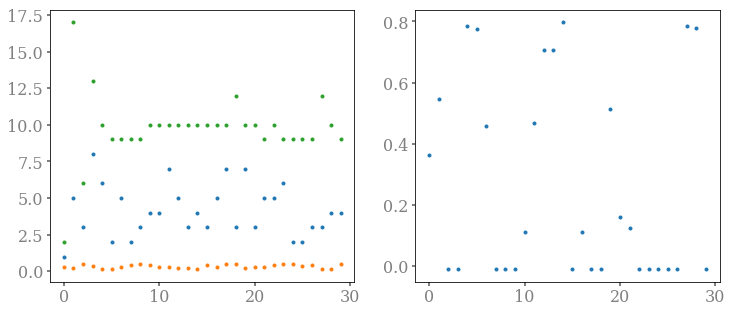

In [40]:
# --- Track the results with each iteration

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(BOout.Xt,'.')
plt.subplot(122)
plt.plot(BOout.Yt,'.')

plt.show()

## Convergence Diagnostics
Plot the convergence of the hyper parameters with each iteration

In [8]:
hps = {
    'n_estimators':range(1,20),
    'max_depth':range(1,10),
    'min_samples_leaf': [0.1,0.5]
}

# --- Run the Bayesian Optimisation Code
MLmodel = RandomForestRegressor(random_state=42)

noise = 0.05
BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = MLmodel,
    NpI = 5,
    Niter = 25,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 10
).optimise()

[autoreload of bayesian_hyperparameter_optimisation_3 failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/crookm12/Documents/GitHub/BayesianOpt

ndim: 1
{'max_depth': 3, 'min_samples_leaf': 0.30000000000000004, 'n_estimators': 13} score: 0.3336931732685191
{'max_depth': 1, 'min_samples_leaf': 0.38, 'n_estimators': 2} score: -0.004065434124759504
{'max_depth': 8, 'min_samples_leaf': 0.22000000000000003, 'n_estimators': 17} score: 0.46907179009709593
{'max_depth': 6, 'min_samples_leaf': 0.4600000000000001, 'n_estimators': 6} score: -0.003851707134288196


INFO:root:Will perform 25 iterations
INFO:root:Iteration 0


{'max_depth': 5, 'min_samples_leaf': 0.14, 'n_estimators': 10} score: 0.7835089048503446
optim rout: minimize
Ncontinous_hps: 1


AttributeError: 'iteration' object has no attribute 'discrete_values'

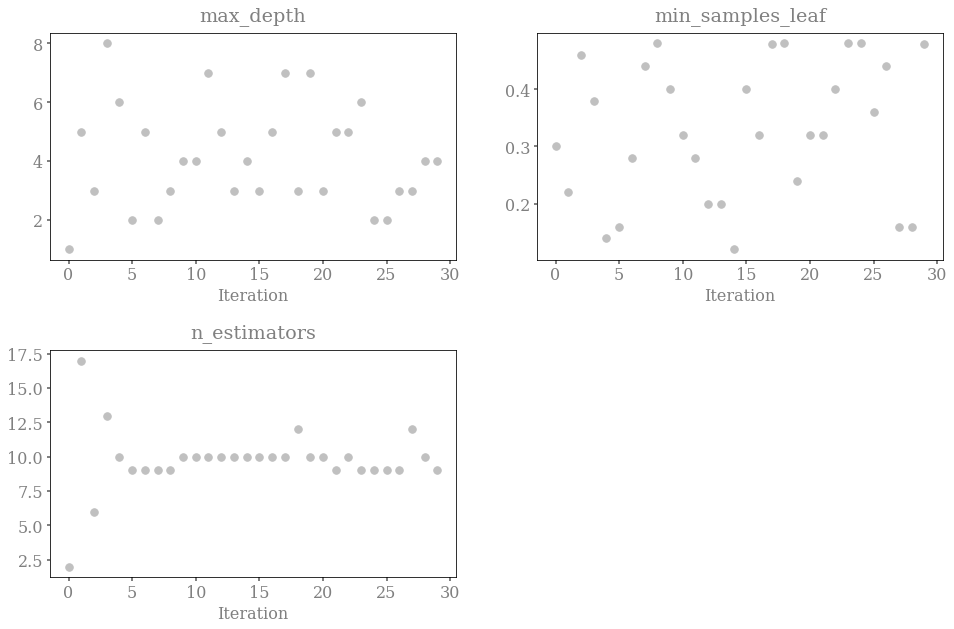

In [39]:
BOout.hyperparameter_convergence_plots()

# Using random_search solver for discrete valued hyperparameters

In [ ]:
training_size = 1000
X_train = 15*np.random.uniform(size=(1000,len(hps)))
# Generate noisy data from a 2D gaussian defined above
y_train = generate_noisy_data_from_bivariate_gaussian_nd(X_train, mu = [5, 10, 15], sig = [1, 5, 10])
y_train = y_train.ravel()

In [92]:
# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,20),
#     'max_depth':range(9,12),
    'min_samples_leaf': [0.0001, 0.5]
}

# --- Run the Bayesian Optimisation Code

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = RandomForestRegressor(random_state=42),
    NpI = 5,
    Niter = 90,
    y_train = y_train,
    X_train = X_train,
    n_restarts = 30,
    optim_rout = 'random_search',
    noise = 0.01,
    xi = 0.01,
    kernel = RBF(length_scale=0.05)
)
BOout.optimise()

{'min_samples_leaf': 0.07547030834984308, 'n_estimators': 16} score: 0.5584880513390935
{'min_samples_leaf': 0.1313787595633155, 'n_estimators': 16} score: 0.3332925418439192
{'min_samples_leaf': 0.02377644683641375, 'n_estimators': 15} score: 0.8440103704569137
{'min_samples_leaf': 0.4674961529225334, 'n_estimators': 6} score: -0.0062162999713587744


INFO:root:Will perform 90 iterations
INFO:root:Iteration 0
INFO:root:Iteration 1


{'min_samples_leaf': 0.0935834539077896, 'n_estimators': 13} score: 0.5461443734942154
final res: [[0.42468673 8.        ]], [-0.39396223]
{'min_samples_leaf': 0.42468673276169594, 'n_estimators': 8} score: -0.006265855560931577
current accuracy: -0.006265855560931577
best accuracy: 0.8440103704569137


INFO:root:Iteration 2
INFO:root:Iteration 3


final res: [[1.e-04 2.e+00]], [-0.0935109]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 2} score: 0.9068410516028582
current accuracy: 0.9068410516028582
best accuracy: 0.9068410516028582
final res: [[0.5 1. ]], [-0.14565325]
{'min_samples_leaf': 0.5, 'n_estimators': 1} score: -0.008509636286777455
current accuracy: -0.008509636286777455
best accuracy: 0.9068410516028582


INFO:root:Iteration 4
INFO:root:Iteration 5


final res: [[1.e-04 3.e+00]], [-0.30963042]
{'min_samples_leaf': 0.0001, 'n_estimators': 3} score: 0.9167277650577057
current accuracy: 0.9167277650577057
best accuracy: 0.9167277650577057
final res: [[0.5 3. ]], [-0.03608805]
{'min_samples_leaf': 0.5, 'n_estimators': 3} score: -0.006129850999767372
current accuracy: -0.006129850999767372
best accuracy: 0.9167277650577057


INFO:root:Iteration 6


final res: [[ 0.5 14. ]], [-0.14731261]
{'min_samples_leaf': 0.5, 'n_estimators': 14} score: -0.007152899677226943
current accuracy: -0.007152899677226943
best accuracy: 0.9167277650577057
final res: [[1.0e-04 1.2e+01]], [-0.13727601]


INFO:root:Iteration 7
INFO:root:Iteration 8


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.938221995813806
final res: [[ 0.5 11. ]], [-0.12702093]
{'min_samples_leaf': 0.5, 'n_estimators': 11} score: -0.006982438596177287
current accuracy: -0.006982438596177287
best accuracy: 0.938221995813806


INFO:root:Iteration 9


final res: [[1.0e-04 1.9e+01]], [-0.09289924]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 10


final res: [[1.0e-04 1.8e+01]], [-0.14198038]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 11


final res: [[ 0.5 19. ]], [-0.12599704]
{'min_samples_leaf': 0.5, 'n_estimators': 19} score: -0.007202174237086201
current accuracy: -0.007202174237086201
best accuracy: 0.9404985167895668


INFO:root:Iteration 12


final res: [[1.e-04 4.e+00]], [-0.09877247]
{'min_samples_leaf': 0.0001, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[ 0.5 12. ]], [-0.08280993]


INFO:root:Iteration 13
INFO:root:Iteration 14


{'min_samples_leaf': 0.5, 'n_estimators': 12} score: -0.0070094705166444
current accuracy: -0.0070094705166444
best accuracy: 0.9404985167895668
final res: [[1.e-04 5.e+00]], [-0.09660672]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668


INFO:root:Iteration 15


final res: [[1.e-04 1.e+01]], [-0.05355742]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 16


final res: [[1.e-04 9.e+00]], [-0.09243895]
{'min_samples_leaf': 0.0001, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668


INFO:root:Iteration 17


final res: [[0.5 9. ]], [-0.05007062]
{'min_samples_leaf': 0.5, 'n_estimators': 9} score: -0.0067357804885472385
current accuracy: -0.0067357804885472385
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.03461644]


INFO:root:Iteration 18
INFO:root:Iteration 19


{'min_samples_leaf': 0.0001, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 4.e+00]], [-0.03052824]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668


INFO:root:Iteration 20


final res: [[1.0e-04 1.8e+01]], [-0.02331839]
{'min_samples_leaf': 0.0001000000000000445, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 21


final res: [[1.e-04 1.e+01]], [-0.02918237]
{'min_samples_leaf': 0.0001, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 22


final res: [[1.0e-04 1.1e+01]], [-0.03534676]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668


INFO:root:Iteration 23


final res: [[1.0e-04 1.1e+01]], [-0.02344155]
{'min_samples_leaf': 0.0001, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668


INFO:root:Iteration 24


final res: [[1.e-04 1.e+01]], [-0.0216114]
{'min_samples_leaf': 0.0001, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 25


final res: [[1.e-04 4.e+00]], [-0.01943199]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.01793224]


INFO:root:Iteration 26


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.01525775]


INFO:root:Iteration 27


{'min_samples_leaf': 0.0001, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.2e+01]], [-0.01470385]


INFO:root:Iteration 28


{'min_samples_leaf': 0.0001, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.01638285]


INFO:root:Iteration 29


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.e-04 4.e+00]], [-0.01412793]


INFO:root:Iteration 30


{'min_samples_leaf': 0.0001, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.1e+01]], [-0.01867754]


INFO:root:Iteration 31


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.01428589]


INFO:root:Iteration 32
INFO:root:Iteration 33


{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668
final res: [[1.e-04 2.e+00]], [-0.01380061]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 2} score: 0.9068410516028582
current accuracy: 0.9068410516028582
best accuracy: 0.9404985167895668


INFO:root:Iteration 34


final res: [[1.e-04 5.e+00]], [-0.01786915]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.01394015]


INFO:root:Iteration 35


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.01228137]


INFO:root:Iteration 36


{'min_samples_leaf': 0.0001, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.1e+01]], [-0.01552368]


INFO:root:Iteration 37


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.01337585]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668


INFO:root:Iteration 38
INFO:root:Iteration 39


final res: [[1.0e-04 1.2e+01]], [-0.01250772]
{'min_samples_leaf': 0.0001, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668


INFO:root:Iteration 40


final res: [[1.e-04 5.e+00]], [-0.01317915]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668


INFO:root:Iteration 41


final res: [[1.0e-04 1.1e+01]], [-0.01342077]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.01322106]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 42
INFO:root:Iteration 43


final res: [[1.0e-04 1.9e+01]], [-0.01272487]
{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 44


final res: [[1.0e-04 1.8e+01]], [-0.01172425]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 45


final res: [[1.0e-04 1.8e+01]], [-0.01056484]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 46


final res: [[1.e-04 4.e+00]], [-0.01093917]
{'min_samples_leaf': 0.0001, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.e-04 4.e+00]], [-0.00901733]


INFO:root:Iteration 47


{'min_samples_leaf': 0.0001, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00963376]


INFO:root:Iteration 48


{'min_samples_leaf': 0.0001, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.01145427]


INFO:root:Iteration 49


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.2e+01]], [-0.01063531]


INFO:root:Iteration 50


{'min_samples_leaf': 0.0001, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.01113549]


INFO:root:Iteration 51


{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.01067933]


INFO:root:Iteration 52


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.01005781]


INFO:root:Iteration 53


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668
final res: [[1.e-04 5.e+00]], [-0.01014542]
{'min_samples_leaf': 0.0001, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668


INFO:root:Iteration 54
INFO:root:Iteration 55


final res: [[1.0e-04 1.2e+01]], [-0.00951878]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668


INFO:root:Iteration 56


final res: [[1.0e-04 1.1e+01]], [-0.01142807]
{'min_samples_leaf': 0.0001, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668


INFO:root:Iteration 57


final res: [[1.0e-04 1.1e+01]], [-0.01028276]
{'min_samples_leaf': 0.0001, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.1e+01]], [-0.00936561]


INFO:root:Iteration 58


{'min_samples_leaf': 0.0001, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00886543]


INFO:root:Iteration 59


{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.00960333]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 60
INFO:root:Iteration 61


final res: [[1.0e-04 1.2e+01]], [-0.00850724]
{'min_samples_leaf': 0.0001, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668


INFO:root:Iteration 62


final res: [[1.e-04 3.e+00]], [-0.00846399]
{'min_samples_leaf': 0.0001, 'n_estimators': 3} score: 0.9167277650577057
current accuracy: 0.9167277650577057
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.1e+01]], [-0.008632]


INFO:root:Iteration 63
INFO:root:Iteration 64


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 11} score: 0.9385130140737641
current accuracy: 0.9385130140737641
best accuracy: 0.9404985167895668
final res: [[1.e-04 2.e+00]], [-0.00850273]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 2} score: 0.9068410516028582
current accuracy: 0.9068410516028582
best accuracy: 0.9404985167895668


INFO:root:Iteration 65


final res: [[1.e-04 1.e+01]], [-0.00872552]
{'min_samples_leaf': 0.0001, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 66


final res: [[1.e-04 1.e+01]], [-0.00805871]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 67


final res: [[1.e-04 9.e+00]], [-0.00890706]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668


INFO:root:Iteration 68


final res: [[1.0e-04 1.9e+01]], [-0.00995574]
{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 69


final res: [[1.0e-04 1.8e+01]], [-0.00821806]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 70


final res: [[1.e-04 5.e+00]], [-0.00807507]
{'min_samples_leaf': 0.0001, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.00906316]
{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 71


final res: [[1.0e-04 1.9e+01]], [-0.00836354]
{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668


INFO:root:Iteration 72
INFO:root:Iteration 73


final res: [[1.e-04 4.e+00]], [-0.0077194]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.00777608]


INFO:root:Iteration 74


{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00766414]


INFO:root:Iteration 75


{'min_samples_leaf': 0.00010000000000001674, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 1.e+01]], [-0.00741891]


INFO:root:Iteration 76


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00718315]


INFO:root:Iteration 77


{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.8e+01]], [-0.00676075]


INFO:root:Iteration 78


{'min_samples_leaf': 0.0001, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.00791135]


INFO:root:Iteration 79


{'min_samples_leaf': 0.0001, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668
final res: [[1.e-04 9.e+00]], [-0.00720254]


INFO:root:Iteration 80


{'min_samples_leaf': 0.0001, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668
final res: [[1.e-04 5.e+00]], [-0.00682556]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 5} score: 0.9280930833852047
current accuracy: 0.9280930833852047
best accuracy: 0.9404985167895668


INFO:root:Iteration 81
INFO:root:Iteration 82


final res: [[1.e-04 3.e+00]], [-0.00636478]
{'min_samples_leaf': 0.0001, 'n_estimators': 3} score: 0.9167277650577057
current accuracy: 0.9167277650577057
best accuracy: 0.9404985167895668
final res: [[1.0e-04 1.9e+01]], [-0.00717994]


INFO:root:Iteration 83


{'min_samples_leaf': 0.0001, 'n_estimators': 19} score: 0.9404985167895668
current accuracy: 0.9404985167895668
best accuracy: 0.9404985167895668
final res: [[1.e-04 4.e+00]], [-0.0066389]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668


INFO:root:Iteration 84
INFO:root:Iteration 85


final res: [[1.0e-04 1.8e+01]], [-0.0063861]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Iteration 86


final res: [[1.e-04 1.e+01]], [-0.00685151]
{'min_samples_leaf': 0.0001000000000000098, 'n_estimators': 10} score: 0.938477864245615
current accuracy: 0.938477864245615
best accuracy: 0.9404985167895668


INFO:root:Iteration 87


final res: [[1.e-04 9.e+00]], [-0.00659591]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 9} score: 0.9368022364613532
current accuracy: 0.9368022364613532
best accuracy: 0.9404985167895668


INFO:root:Iteration 88


final res: [[1.0e-04 1.2e+01]], [-0.00752724]
{'min_samples_leaf': 0.00010000000000000286, 'n_estimators': 12} score: 0.938221995813806
current accuracy: 0.938221995813806
best accuracy: 0.9404985167895668


INFO:root:Iteration 89


final res: [[1.0e-04 1.8e+01]], [-0.00605124]
{'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 18} score: 0.9404707626533824
current accuracy: 0.9404707626533824
best accuracy: 0.9404985167895668


INFO:root:Best result 0.9404985167895668: Params: [1.0e-04 1.9e+01]
INFO:root:Best result 0.9404985167895668: Params: {'min_samples_leaf': 9.999999999998899e-05, 'n_estimators': 19.0}


final res: [[1.e-04 4.e+00]], [-0.00574184]
{'min_samples_leaf': 0.00010000000000001674, 'n_estimators': 4} score: 0.9259890334724702
current accuracy: 0.9259890334724702
best accuracy: 0.9404985167895668


/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend.qt4', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'datapath', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'docstring.hardcopy', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core

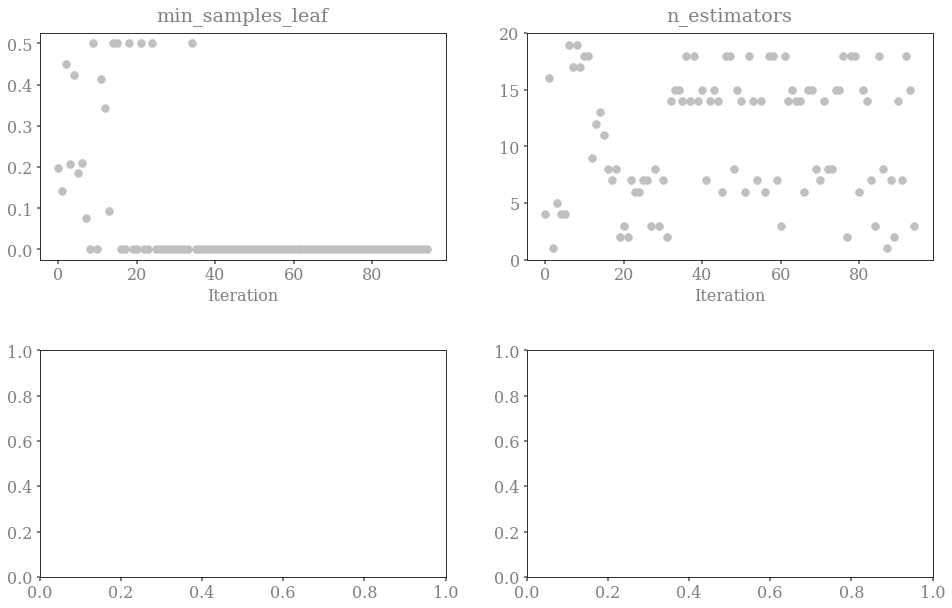

In [82]:
BOout.hyperparameter_convergence_plots()

/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend.qt4', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'datapath', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:100: UserWarning: Style includes a parameter, 'docstring.hardcopy', that is not related to style.  Ignoring
  _apply_style(style)
/anaconda3/lib/python3.6/site-packages/matplotlib/style/core

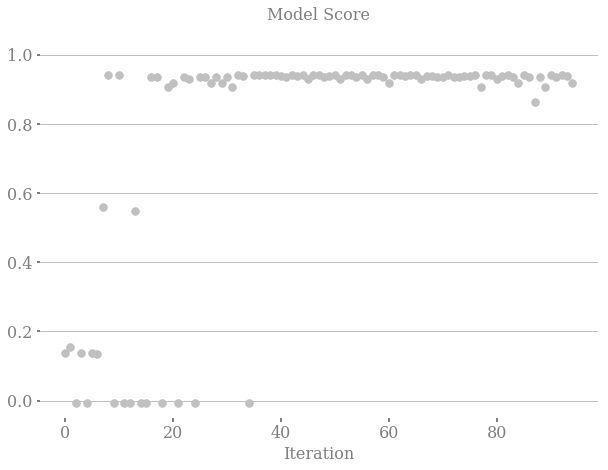

In [83]:
BOout.model_accuracy_convergence_plot()

In [95]:
BOout.best_params_vals

array([1.0e-04, 1.9e+01])

# Ignore this for now...

In [165]:
# X = np.zeros((ndim, len(hps)))
# X[:, 0] = np.random.choice(hps[sorted(hps)[0]], size = ndim)#BOout.best_params_vals[0]
# X[:, 1] = np.linspace(0.1, 0.5, ndim)
# X[:, 2] = np.random.choice(hps[sorted(hps)[2]], size = ndim)#BOout.best_params_vals[2]

noise = 0.001
# x=np.linspace(0.1, 0.5).reshape(-1,1)
y, std = BOout.gpr.predict(X, return_std=True)
y1, std1 = GaussianProcessRegressor(kernel=RBF(), alpha=0.1).fit(BOout.Xt[:, 1].reshape(-1, 1), BOout.Yt).predict(X[:,1].reshape(-1, 1), return_std=True)
plt.plot(X[:,1], y)
# plt.plot(X[:,1], y - std, '--')
# plt.plot(X[:,1], y + std, '--')
plt.plot(BOout.Xt[:,1], BOout.Yt, '.')
plt.plot(X[:,1], y1, '.')

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

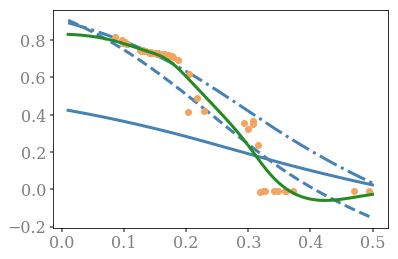

In [175]:
ndim = BOout.Xt.shape[0]

X = np.zeros((ndim, 4))
X[:, 0] = np.linspace(0.01, 0.5, ndim)
for i in range(1, 4):
    X[:, i] = i
    
plot_i = 1
y, std = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)
plot_i = 2
y_, std_ = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)
plot_i = 3
y__, std__ = BOout.gpr.predict(X[:, [0, plot_i]], return_std=True)

y1, std1 = GaussianProcessRegressor(kernel=Matern(), alpha=0.0125).fit(BOout.Xt[:, 0].reshape(-1, 1), BOout.Yt)\
    .predict(X[:,[0]], return_std=True)

plt.plot(X[:,0], y, color = 'steelblue', linewidth = 3)
plt.plot(X[:,0], y_, '--', color = 'steelblue', linewidth = 3)
plt.plot(X[:,0], y__, '-.', color = 'steelblue', linewidth = 3)
plt.plot(BOout.Xt[:,0], BOout.Yt, '.', color = 'sandybrown', markersize = 12)
plt.plot(X[:,0], y1, color = 'forestgreen', linewidth = 3)

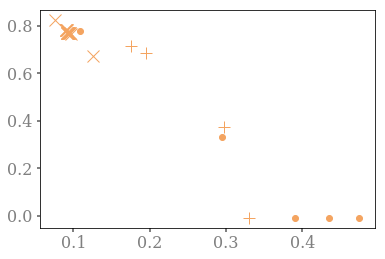

In [143]:
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 1, 0], BOout.Yt[BOout.Xt[:, 1] == 1], 'x', color = 'sandybrown', markersize = 12)
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 2, 0], BOout.Yt[BOout.Xt[:, 1] == 2], '.', color = 'sandybrown', markersize = 12)
plt.plot(BOout.Xt[BOout.Xt[:, 1] == 3, 0], BOout.Yt[BOout.Xt[:, 1] == 3], '+', color = 'sandybrown', markersize = 12)

In [26]:
noise = 0.001
# x=np.linspace(0.1, 0.5).reshape(-1,1)
y, std = BOout.gpr.predict(X, return_std=True)
y1, std1 = GaussianProcessRegressor(kernel=RBF(), alpha=0.1).fit(BOout.Xt[:, 1].reshape(-1, 1), BOout.Yt).predict(X[:,1].reshape(-1, 1), return_std=True)
plt.plot(X[:,1], y)
# plt.plot(X[:,1], y - std, '--')
# plt.plot(X[:,1], y + std, '--')
plt.plot(BOout.Xt[:,1], BOout.Yt, '.')
plt.plot(X[:,1], y1, '.')

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [146]:
y1


array([-1.83090872e-007,  9.33336254e-061,  3.23542516e-121,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        1.79261038e-119, -2.02127050e-301, -2.65832982e-301,
       -3.23918971e-242,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  4.76520317e-001,  0.00000000e+000,
        1.12019470e-295,  0.00000000e+000,  4.05230613e-060,
        6.15450612e-238,  0.00000000e+000, -2.00465774e-125,
        1.13053885e-059,  8.99325934e-120,  1.34607900e-059,
        0.00000000e+000, -1.08859087e-301,  6.85738453e-119,
        1.80735970e-237,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  6.00695818e-001,  0.00000000e+000,
        0.00000000e+000, -1.09054977e-298,  0.00000000e+000,
        0.00000000e+000,  1.08444270e-060,  1.98584291e-296,
       -4.03984531e-062,  0.00000000e+000,  0.00000000e+000,
       -9.88845497e-064,  0.00000000e+000, -2.94823117e-121,
        0.00000000e+000,